# Toronto Housing Prices Project

## Question: Why are houses so expensive in Toronto?
There has been a lot of public debate
recently about housing prices in Toronto. The cost of living is becoming unaffordable for
many Torontonians and home ownership has become unfeasible for a growing
percentage of the population. There have been lots of explanations offered and
solutions presented from across the political spectrum, yet the data underlying many of
these arguments seems surprisingly scarce and the arguments surprisingly
non-quantitative. Using any means accessible to you as a private citizen, and any data
available that you deem relevant, can you propose what you think is the most important
cause of high prices (e.g. lack of supply, lending policy, speculation/foreign ownership,
tax policy etc.). Based on this, what are one or two policy proposals that are most likely
to reduce housing prices by the largest magnitude? (Note: Don’t worry about potential
adverse side effects of such proposals. The goal of the exercise is to come up with a
good simplified model of the housing market, not to come up with policy proposals you
would necessarily vote for.).<br>
<br>
To start answering this question, first we need to determine what parameters affect housing prices in Toronto.<br>
<br>
A study by Royal Bank of Canada and the Pambia Institute indicated following parameters affect housing prices in Toronto:
<br>
* Real income and demographics
* The cost and accessibility of mortgages
* Construction and development costs
* Land availability and regulations
* Location and housing stock supply and demand

Source:<br> 
Pambia Institute:Understanding the factors affecting home prices in the GTA (https://www.pembina.org/pub/2502).<br>
<br>
Data from different sources (cited at the end) where gathered and compiled to take these factors into account in this anaysis:
<br>
* Monthly Home Transactions: database containing monthly house sales information.
* Ontario Employment Wages: Monthly wages across Ontario.
* Land Pricing Index: Land price index in Toronto.
* Mortgage Rates: prime and mortgage retes.
* Average Residential Building Construction Price Index: an indec showing residential building costs in Toronto.<br>
<br>

In addition, a sixth parameter; total jobs in city of Toronto is also included.

### Based on data availability, monthly data for an 11 years window from January 2011 to December 2021 is considered in this analysis.

The structure of this report is as follow:<br>
<br>
1- Data<br>
2- Exploratory Data Analysis<br>
3- Forecasting Housing Prices<br>
4- Summary, recommendations and future work<br>




In [56]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import math

from statsmodels.tsa.stattools import grangercausalitytests
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

In [2]:
wage = pd.read_csv('Data/OntarioEmploymentWages_2011-2021.csv')
land = pd.read_csv('Data/Land_pricing_index-2011-2021.csv')
ht = pd.read_csv('Data/MonthlyHomeTransactions.csv')
mort = pd.read_csv('Data/Mortgage_rates_2011-2021.csv')
rbcpi = pd.read_csv('Data/Residential_Building_Construction_Price_Index_2011-2021.csv')
employ = pd.read_csv('Data/Total_employment.csv')


## 1- Data

In this section I'll explain databases used for this analysis:

### 1.1 - Monthly Home Transactions:
This file contains information related to monthly house sales in city of Toronto:<br>
housing prices (Avg. Price Level, Median Price)<br>
Number od sales: Number of houses sold in each month<br>
New listings<br>
active listings<br>
Avg. SP/LP: Average sale price over listing price<br>
Avg. DOM: Average days on market<br>

In [3]:
 # Load data
ht = ht.drop([ 'Date'], axis = 1) #Date column format is not correct so I'll remove it and craete a new one
min_month = "2011-01"
max_month = "2021-12"
 
ht['Date'] = pd.period_range(min_month, max_month, freq='M')

# move new Date column to second column for better visualization
ht = ht[['ID', 'Date', 'Number of Sales', 'Dollar Volume', 'Avg. Price Level',
       'Median Price', 'New Listings', 'SNLR (Trend)', 'Active Listings',
       'Mos. Inv. (Trend)', 'Avg. SP/LP', 'Avg. DOM']]

ht.head()

,ID,Date,Number of Sales,Dollar Volume,Avg. Price Level,Median Price,New Listings,SNLR (Trend),Active Listings,Mos. Inv. (Trend),Avg. SP/LP,Avg. DOM
0,1,2011-01,"4,337","1,852,057,481","$427,037","$360,000","9,008",NaN,"12,152",NaN,98%,36
1,2,2011-02,"6,266","2,847,415,540","$454,423","$379,000","11,538",NaN,"14,365",NaN,99%,27
2,3,2011-03,"9,262","4,224,832,331","$456,147","$385,000","15,315",NaN,"16,616",NaN,99%,23
3,4,2011-04,"9,041","4,316,236,999","$477,407","$402,000","14,494",NaN,"17,466",NaN,99%,22
4,5,2011-05,"10,046","4,877,529,408","$485,520","$400,000","16,076",NaN,"18,481",NaN,99%,23


### 1.2 - Ontario Employment Wages 2011 to 2021:
This dataset lists total wages by month across Ontario. I could not find sources specific to city of Toronto and used this data instead. therfore:
* **Assumption: Wages in Toronto correlate/are silimar to that of Ontario**

More information on this dataset is provided at: "Employment_Wages_Canada.ipynb" included with this file.

In [4]:
wage.rename(columns={'VALUE': 'wage_value'}, inplace=True)
wage.head()

,ID,REF_DATE,GEO,DGUID,Wages,Type of work,National Occupational Classification (NOC),Sex,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,wage_value,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1,11-Jan,Ontario,2016A000235,"Total employees, all wages",Both full- and part-time employees,"Total employees, all occupations",Both sexes,15 years and over,Persons,249,thousands,3,v103504914,7.1.1.1.1.1,5517.1,NaN,NaN,NaN,1
1,2,11-Feb,Ontario,2016A000235,"Total employees, all wages",Both full- and part-time employees,"Total employees, all occupations",Both sexes,15 years and over,Persons,249,thousands,3,v103504914,7.1.1.1.1.1,5540.8,NaN,NaN,NaN,1
2,3,11-Mar,Ontario,2016A000235,"Total employees, all wages",Both full- and part-time employees,"Total employees, all occupations",Both sexes,15 years and over,Persons,249,thousands,3,v103504914,7.1.1.1.1.1,5543.4,NaN,NaN,NaN,1
3,4,11-Apr,Ontario,2016A000235,"Total employees, all wages",Both full- and part-time employees,"Total employees, all occupations",Both sexes,15 years and over,Persons,249,thousands,3,v103504914,7.1.1.1.1.1,5596.2,NaN,NaN,NaN,1
4,5,11-May,Ontario,2016A000235,"Total employees, all wages",Both full- and part-time employees,"Total employees, all occupations",Both sexes,15 years and over,Persons,249,thousands,3,v103504914,7.1.1.1.1.1,5704.3,NaN,NaN,NaN,1


### 1.3 - Land Pricing Index 2011 to 2021:

As a proxy for land availability and regulations (data source at the end of file).<br>

* Index, 2017=100

In [5]:
land.rename(columns={'VALUE': 'land_value'}, inplace=True)
land.head()

,ID,Date,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,land_value,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1,11-Jan,"Toronto, Ontario",2011S0503535,Land only,"Index, 201612=100",347,units,0,v111955501,20.3,87.7,E,NaN,NaN,1
1,2,11-Feb,"Toronto, Ontario",2011S0503535,Land only,"Index, 201612=100",347,units,0,v111955501,20.3,87.7,E,NaN,NaN,1
2,3,11-Mar,"Toronto, Ontario",2011S0503535,Land only,"Index, 201612=100",347,units,0,v111955501,20.3,87.7,E,NaN,NaN,1
3,4,11-Apr,"Toronto, Ontario",2011S0503535,Land only,"Index, 201612=100",347,units,0,v111955501,20.3,87.7,E,NaN,NaN,1
4,5,11-May,"Toronto, Ontario",2011S0503535,Land only,"Index, 201612=100",347,units,0,v111955501,20.3,88.2,E,NaN,NaN,1


### 1.4 - Mortgage Rates 2011 to 2021:

Data gathered from bank of Canada (data source at the end of file).

In [12]:
mort.head()

,ID,Date,Prime_rate,mortgare_1y,mortgare_3y,mortgare_5y,Date.1
0,1,11-Jan,3.0,3.35,4.15,5.19,11-Jan
1,2,11-Feb,3.0,3.35,4.15,5.19,11-Feb
2,3,11-Mar,3.0,3.50,4.35,5.44,11-Mar
3,4,11-Apr,3.0,3.70,4.55,5.69,11-Apr
4,5,11-May,3.0,3.70,4.55,5.69,11-May


### 1.5 - Average Residential Building Construction Price Index 2011 to 2021:

* Index, 2017=100

In [7]:
rbcpi.head()

,ID,Date,Ave_RBCPI
0,1,11-Jan,87.2
1,2,11-Feb,87.2
2,3,11-Mar,87.2
3,4,11-Apr,88.5
4,5,11-May,88.5


### 1.6 - Ontario Total Employment 2011 to 2021:

* This data is reported on a yearly basis.<br>

**Assumption: For this analysis yearly values are divided by 12 as a monthly value.**

In [8]:
employ.head()

,ID,Date,Yearly Total Employement,Monthly Employment
0,1,11-Jan,"1,317,300",109775.0
1,2,11-Feb,"1,317,300",109775.0
2,3,11-Mar,"1,317,300",109775.0
3,4,11-Apr,"1,317,300",109775.0
4,5,11-May,"1,317,300",109775.0


### 1.7 - Final dataset:

Combine data to form the "Housing Price Toronto (hpt)" dataset.

In [6]:
# merge all datasets on IDs
merged = []
mort = mort.drop([ 'Date'], axis=1)
mort = mort.drop([ 'Date.1'], axis=1)
employ = employ.drop([ 'Date'], axis=1)
rbcpi = rbcpi.drop([ 'Date'], axis=1)
land = land.drop([ 'Date'], axis=1)
merged = pd.merge(ht, land, on="ID")
merged = pd.merge(merged, mort, on="ID")
merged = pd.merge(merged, rbcpi, on="ID")
merged = pd.merge(merged, employ, on="ID")
merged = pd.merge(merged, wage, on="ID")

In [9]:
merged.columns

Index(['ID', 'Date', 'Number of Sales', 'Dollar Volume', 'Avg. Price Level',
       'Median Price', 'New Listings', 'SNLR (Trend)', 'Active Listings',
       'Mos. Inv. (Trend)', 'Avg. SP/LP', 'Avg. DOM', 'GEO_x', 'DGUID_x',
       'New housing price indexes', 'UOM_x', 'UOM_ID_x', 'SCALAR_FACTOR_x',
       'SCALAR_ID_x', 'VECTOR_x', 'COORDINATE_x', 'land_value', 'STATUS_x',
       'SYMBOL_x', 'TERMINATED_x', 'DECIMALS_x', 'Prime_rate', 'mortgare_1y',
       'mortgare_3y', 'mortgare_5y', 'Ave_RBCPI', 'Yearly Total Employement',
       'Monthly Employment', 'REF_DATE', 'GEO_y', 'DGUID_y', 'Wages',
       'Type of work', 'National Occupational Classification (NOC)', 'Sex',
       'Age group', 'UOM_y', 'UOM_ID_y', 'SCALAR_FACTOR_y', 'SCALAR_ID_y',
       'VECTOR_y', 'COORDINATE_y', 'wage_value', 'STATUS_y', 'SYMBOL_y',
       'TERMINATED_y', 'DECIMALS_y'],
      dtype='object')

In [7]:
# drop unwanted columns
hpt = []
hpt = merged.drop([ 'Dollar Volume','SNLR (Trend)','Mos. Inv. (Trend)', 'GEO_x',
       'DGUID_x', 'New housing price indexes', 'UOM_x', 'UOM_ID_x',
       'SCALAR_FACTOR_x', 'SCALAR_ID_x', 'VECTOR_x', 'COORDINATE_x',
       'STATUS_x', 'SYMBOL_x', 'TERMINATED_x', 'DECIMALS_x',
       'Yearly Total Employement','REF_DATE', 'GEO_y', 'DGUID_y', 'Wages',
       'Type of work', 'National Occupational Classification (NOC)', 'Sex',
       'Age group', 'UOM_y', 'UOM_ID_y', 'SCALAR_FACTOR_y', 'SCALAR_ID_y',
       'VECTOR_y', 'COORDINATE_y', 'STATUS_y', 'SYMBOL_y',
       'TERMINATED_y', 'DECIMALS_y'], axis=1)

In [8]:
hpt.head()

,ID,Date,Number of Sales,Avg. Price Level,Median Price,New Listings,Active Listings,Avg. SP/LP,Avg. DOM,land_value,Prime_rate,mortgare_1y,mortgare_3y,mortgare_5y,Ave_RBCPI,Monthly Employment,wage_value
0,1,2011-01,"4,337","$427,037","$360,000","9,008","12,152",98%,36,87.7,3.0,3.35,4.15,5.19,87.2,109775.0,5517.1
1,2,2011-02,"6,266","$454,423","$379,000","11,538","14,365",99%,27,87.7,3.0,3.35,4.15,5.19,87.2,109775.0,5540.8
2,3,2011-03,"9,262","$456,147","$385,000","15,315","16,616",99%,23,87.7,3.0,3.50,4.35,5.44,87.2,109775.0,5543.4
3,4,2011-04,"9,041","$477,407","$402,000","14,494","17,466",99%,22,87.7,3.0,3.70,4.55,5.69,88.5,109775.0,5596.2
4,5,2011-05,"10,046","$485,520","$400,000","16,076","18,481",99%,23,88.2,3.0,3.70,4.55,5.69,88.5,109775.0,5704.3


## 2 - Exploratory Data Analysis

Some cleaning before we start:

In [9]:
# move 'Avg. Price Level' and 'Median Price' to last for plotting purposes
hpt = hpt[['ID', 'Date', 'Number of Sales',
       'New Listings', 'Active Listings', 'Avg. SP/LP', 'Avg. DOM',
       'land_value','Ave_RBCPI', 'Prime_rate', 'mortgare_1y', 'mortgare_3y', 'mortgare_5y',
        'Monthly Employment', 'wage_value', 'Avg. Price Level', 'Median Price']]

In [10]:
#convert objects to integers
hpt["Number of Sales"]=hpt["Number of Sales"].astype(str).str.replace('[\,\,\.]', '').astype(int)
hpt["New Listings"]=hpt["New Listings"].astype(str).str.replace('[\,\,\.]', '').astype(int)
hpt["Active Listings"]=hpt["Active Listings"].astype(str).str.replace('[\,\,\.]', '').astype(int)
hpt["Avg. SP/LP"]=hpt["Avg. SP/LP"].str.replace('[\%\,\.]', '').astype(int)
hpt["Avg. Price Level"]=hpt["Avg. Price Level"].str.replace('[\$\,\.]', '').astype(int)
hpt["Median Price"]=hpt["Median Price"].str.replace('[\$\,\.]', '').astype(int)

C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future ver

In [76]:
hpt.head()

,ID,Date,Number of Sales,New Listings,Active Listings,Avg. SP/LP,Avg. DOM,land_value,Ave_RBCPI,Prime_rate,mortgare_1y,mortgare_3y,mortgare_5y,Monthly Employment,wage_value,Avg. Price Level,Median Price
0,1,2011-01,4337,9008,12152,98,36,87.7,87.2,3.0,3.35,4.15,5.19,109775.0,5517.1,427037,360000
1,2,2011-02,6266,11538,14365,99,27,87.7,87.2,3.0,3.35,4.15,5.19,109775.0,5540.8,454423,379000
2,3,2011-03,9262,15315,16616,99,23,87.7,87.2,3.0,3.50,4.35,5.44,109775.0,5543.4,456147,385000
3,4,2011-04,9041,14494,17466,99,22,87.7,88.5,3.0,3.70,4.55,5.69,109775.0,5596.2,477407,402000
4,5,2011-05,10046,16076,18481,99,23,88.2,88.5,3.0,3.70,4.55,5.69,109775.0,5704.3,485520,400000


In [11]:
hpt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 131
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   ID                  132 non-null    int64    
 1   Date                132 non-null    period[M]
 2   Number of Sales     132 non-null    int32    
 3   New Listings        132 non-null    int32    
 4   Active Listings     132 non-null    int32    
 5   Avg. SP/LP          132 non-null    int32    
 6   Avg. DOM            132 non-null    int64    
 7   land_value          132 non-null    float64  
 8   Ave_RBCPI           132 non-null    float64  
 9   Prime_rate          132 non-null    float64  
 10  mortgare_1y         132 non-null    float64  
 11  mortgare_3y         132 non-null    float64  
 12  mortgare_5y         132 non-null    float64  
 13  Monthly Employment  120 non-null    float64  
 14  wage_value          132 non-null    float64  
 15  Avg. Price Level    132

* 12 missing values in 'Monthly Employment' bacause data for 2021 is not available yet.

**Assumption: I will replace 2021 missing values with the average of previous years.**

In [12]:
hpt['Monthly Employment']= hpt['Monthly Employment'].fillna(hpt['Monthly Employment'].mean())

### House average price or median?

As I don't have access to individual housing prices and can't check their distribution but let's see how they look like:

<AxesSubplot:xlabel='Date'>

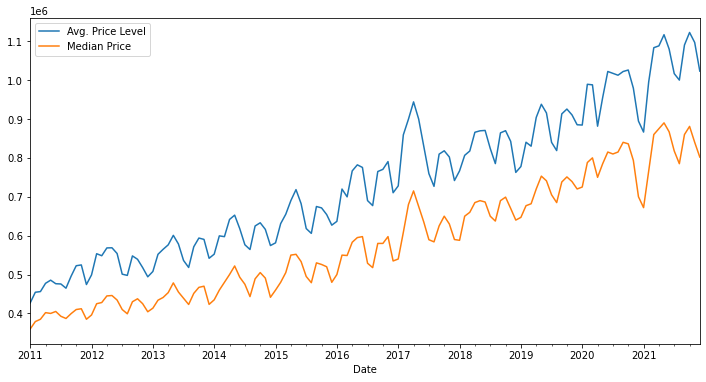

In [13]:
hpt.plot(x="Date", y=["Avg. Price Level", "Median Price"], kind="line",figsize=(12,6))

In [14]:
# Average and median of house prices correlation:
hpt["Avg. Price Level"].corr(hpt["Median Price"])

0.9926457617119436

* They have 99% correlation, this can also be seen from the above plot. In this case, I don't think it really matters which one to choose.<br>
* **Assumption: distribution of housing prices are normal therefore I'll continue with average prices.**

In [15]:
# drop median price column
hpt = hpt.drop(["Median Price"], axis =1)
# save final dataset
hpt.to_csv('Housing_Prices_Toronto.csv')

### 2.1 Correlation analysis

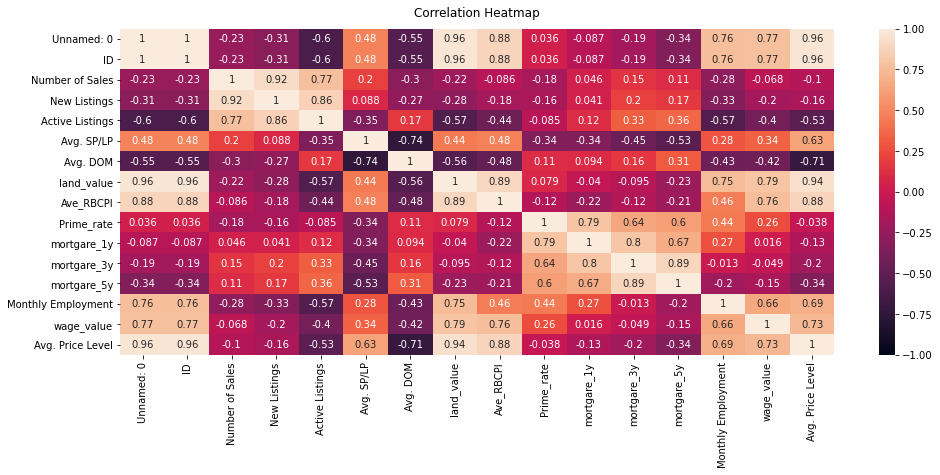

In [57]:
# load data
hpt = pd.read_csv("Housing_Prices_Toronto.csv") 
plt.figure(figsize=(16, 6))
heatmap = sn.heatmap(hpt.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [83]:
# parameters with highest correlation with Avg. Price Level
hpt.corr().sort_values(["Avg. Price Level"], ascending = False).drop(['ID','Number of Sales','New Listings','Active Listings','Avg. SP/LP','Avg. DOM','land_value','Ave_RBCPI','Prime_rate','mortgare_1y','mortgare_3y','mortgare_5y','Monthly Employment','wage_value'], axis=1)

,Avg. Price Level
Avg. Price Level,1.000000
ID,0.961146
land_value,0.943422
Ave_RBCPI,0.876921
wage_value,0.733938
Monthly Employment,0.691147
Avg. SP/LP,0.627999
Prime_rate,-0.037670
Number of Sales,-0.102699
mortgare_1y,-0.125490


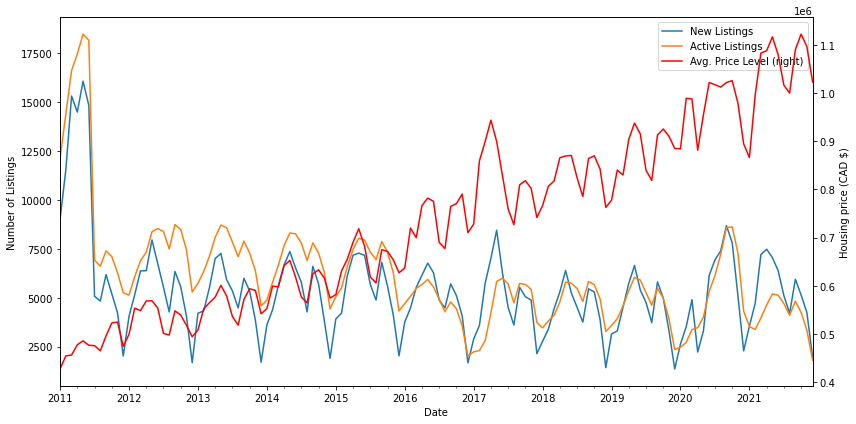

In [84]:
ax = hpt.plot(x="Date", y=['New Listings', 'Active Listings'],figsize=(12,6))

ax2 = hpt.plot(x="Date", y="Avg. Price Level",secondary_y=True,color='Red', ax=ax)

ax.set_ylabel('Number of Listings')
ax2.set_ylabel('Housing price (CAD $)')
plt.tight_layout()
plt.show()

### Correlation analysis observations:

* Land value, average residential building construction costs and wages are top three parameters with highest positive correlation with average house prices in Toronto. Interpretation: as land and construction costs become more expensive so does house prices.<br> 
 <br>
* Interpreting average wages in Toronto is more difficult as this value is for all of Ontario. However, it can be interpreted as higher salaries causes housing prices to increase because on average, people can afford to pay more.<br>
 <br>
* Average days on market has highest negative correlation with housing prices. To me this is an indication of "competitiveness" in buyers market: since housing prices are increasing buyers can't wait too long otherwise they might not be able to afford the listing that they're interested in.<br>
 <br>
* New and active listings have low correlation with housing prices. however it's interesting to see that in 2017 after an increase in housing prices, these listing also increase and in 2020, there is an increase in listings right before prices decrease.<br>
 <br>
* These interpretations require further consultation with subject expert matters.

### 2.2 - Causality test

As we know, correlation is not causation. In this section, I'll use Granger causality test to analyze the causality between parameters and housing prices.<br>
<br>
The Granger causality test is a statistical hypothesis test for determining whether one time series is a factor and offer useful information in forecasting another time series which can be very useful in this analysis.<br>

This test uses the following null and alternative hypotheses:<br>
<br>
* Null Hypothesis (H0): Time series x does not Granger-cause time series y.<br>
<br>
* Alternative Hypothesis (HA): Time series x Granger-causes time series y.

The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful for predicting the value of time series y at a later time period.

In [58]:
# load data
hpt = pd.read_csv("Housing_Prices_Toronto.csv") 
#perform Granger-Causality test
grangercausalitytests(hpt[['Avg. Price Level', 'land_value']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3722  , p=0.0027  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=9.5918  , p=0.0020  , df=1
likelihood ratio test: chi2=9.2569  , p=0.0023  , df=1
parameter F test:         F=9.3722  , p=0.0027  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7776  , p=0.0001  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=20.3375 , p=0.0000  , df=2
likelihood ratio test: chi2=18.8953 , p=0.0001  , df=2
parameter F test:         F=9.7776  , p=0.0001  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3386  , p=0.0769  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=7.4183  , p=0.0597  , df=3
likelihood ratio test: chi2=7.2128  , p=0.0654  , df=3
parameter F test:         F=2.3386  , p=0.0769  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8912  , p=0.4715  

{1: ({'ssr_ftest': (9.372168697179848, 0.0026852427288854134, 128.0, 1),
   'ssr_chi2test': (9.591828901020001, 0.0019544517284099177, 1),
   'lrtest': (9.256923551641648, 0.0023460679007322816, 1),
   'params_ftest': (9.372168697179875, 0.0026852427288853687, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.777643694216868, 0.00011343627898247185, 125.0, 2),
   'ssr_chi2test': (20.337498883971083, 3.8350252656977944e-05, 2),
   'lrtest': (18.895280138496673, 7.887548649102876e-05, 2),
   'params_ftest': (9.777643694216705, 0.00011343627898248733, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.338572799874251, 0.07686478605263884, 122.0, 3),
   'ssr_chi2test': (7.418259619273239, 0.05969633000540252, 3),
   'lrtest': (7.212802834138074, 0.06541560846120117, 3),
   'params_ftest': (2.3385727998742363, 0.07686478605264067, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

* Up to lag 2, p-value is less than 5% and we can reject null hypothesis. this means: land values Granger-causes average housing prices. <br>
* In other words, upto lag 2 (two months) land value price index can be used to predict average housing prices.

In [120]:
grangercausalitytests(hpt[['Avg. Price Level', 'Ave_RBCPI']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1901  , p=0.0244  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=5.3118  , p=0.0212  , df=1
likelihood ratio test: chi2=5.2069  , p=0.0225  , df=1
parameter F test:         F=5.1901  , p=0.0244  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3854  , p=0.0144  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=9.1216  , p=0.0105  , df=2
likelihood ratio test: chi2=8.8158  , p=0.0122  , df=2
parameter F test:         F=4.3854  , p=0.0144  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7051  , p=0.1695  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=5.4088  , p=0.1442  , df=3
likelihood ratio test: chi2=5.2985  , p=0.1512  , df=3
parameter F test:         F=1.7051  , p=0.1695  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7729  , p=0.1388  

{1: ({'ssr_ftest': (5.190107755567213, 0.024373230355322916, 128.0, 1),
   'ssr_chi2test': (5.311750906088319, 0.021182057881129195, 1),
   'lrtest': (5.20688651815999, 0.022497588191724278, 1),
   'params_ftest': (5.190107755567202, 0.024373230355323187, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.38538274546981, 0.014431120234702218, 125.0, 2),
   'ssr_chi2test': (9.121596110577203, 0.01045371297267335, 2),
   'lrtest': (8.815806015883936, 0.0121806943864704, 2),
   'params_ftest': (4.385382745469859, 0.014431120234701682, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7051068185664862, 0.16951344034928606, 122.0, 3),
   'ssr_chi2test': (5.408822449059264, 0.14419489750421668, 3),
   'lrtest': (5.298502758570976, 0.15119957433355852, 3),
   'params_ftest': (1.705106818566481, 0.16951344034928753, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

* Same conclusion is viable for average residential building construction costs.

In [59]:
grangercausalitytests(hpt[['Avg. Price Level', 'Monthly Employment']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8671  , p=0.0928  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=2.9343  , p=0.0867  , df=1
likelihood ratio test: chi2=2.9020  , p=0.0885  , df=1
parameter F test:         F=2.8671  , p=0.0928  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0135  , p=0.1378  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=4.1881  , p=0.1232  , df=2
likelihood ratio test: chi2=4.1220  , p=0.1273  , df=2
parameter F test:         F=2.0135  , p=0.1378  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7956  , p=0.4986  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=2.5237  , p=0.4710  , df=3
likelihood ratio test: chi2=2.4993  , p=0.4754  , df=3
parameter F test:         F=0.7956  , p=0.4986  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8890  , p=0.0011  

{1: ({'ssr_ftest': (2.8671484292071883, 0.09283727316866355, 128.0, 1),
   'ssr_chi2test': (2.9343472205167322, 0.08671370912780357, 1),
   'lrtest': (2.9019657848530187, 0.08847159998864053, 1),
   'params_ftest': (2.8671484292076292, 0.09283727316863881, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.0134886640490666, 0.13782979348387933, 125.0, 2),
   'ssr_chi2test': (4.188056421222059, 0.12318990014188462, 2),
   'lrtest': (4.122010330082048, 0.127325921985365, 2),
   'params_ftest': (2.0134886640490657, 0.13782979348387933, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7955782666922965, 0.4986190631084131, 122.0, 3),
   'ssr_chi2test': (2.523678600081301, 0.47102702483536885, 3),
   'lrtest': (2.4993100415567824, 0.47541578718855415, 3),
   'params_ftest': (0.7955782666922805, 0.49861906310842363, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

* This test fails to reject the null hypothesis for 'Monthly Employment' values at first three lags.<br>
* At lags 4 and 5, Monthly Employment Granger-causes average housing prices.

In [121]:
grangercausalitytests(hpt[['Avg. Price Level', 'Prime_rate']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0876  , p=0.7678  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=0.0896  , p=0.7647  , df=1
likelihood ratio test: chi2=0.0896  , p=0.7647  , df=1
parameter F test:         F=0.0876  , p=0.7678  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7416  , p=0.1795  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=3.6226  , p=0.1634  , df=2
likelihood ratio test: chi2=3.5731  , p=0.1675  , df=2
parameter F test:         F=1.7416  , p=0.1795  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4277  , p=0.2380  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=4.5289  , p=0.2097  , df=3
likelihood ratio test: chi2=4.4512  , p=0.2167  , df=3
parameter F test:         F=1.4277  , p=0.2380  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7092  , p=0.1524  

{1: ({'ssr_ftest': (0.08755237331450286, 0.7677916724075368, 128.0, 1),
   'ssr_chi2test': (0.08960438206406152, 0.764680705568411, 1),
   'lrtest': (0.08957375120189681, 0.7647197435867636, 1),
   'params_ftest': (0.08755237331451295, 0.7677916724075368, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.7416421423511061, 0.17945744058139232, 125.0, 2),
   'ssr_chi2test': (3.622615656090301, 0.16344024523007422, 2),
   'lrtest': (3.5730597739025143, 0.16754054673504806, 2),
   'params_ftest': (1.7416421423511106, 0.17945744058139232, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.4277181608333667, 0.2379896263885001, 122.0, 3),
   'ssr_chi2test': (4.52890924788945, 0.20972609820346158, 3),
   'lrtest': (4.45122223342014, 0.21668263756704112, 3),
   'params_ftest': (1.4277181608333678, 0.23798962638849852, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

* The test indicate that 'prime-rate' does not Granger-causes average housing prices.

How about days on market variable?

In [124]:
grangercausalitytests(hpt[['Avg. Price Level', 'Avg. DOM']], maxlag=24)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8979 , p=0.0005  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=13.2002 , p=0.0003  , df=1
likelihood ratio test: chi2=12.5767 , p=0.0004  , df=1
parameter F test:         F=12.8979 , p=0.0005  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4848  , p=0.0004  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=17.6483 , p=0.0001  , df=2
likelihood ratio test: chi2=16.5488 , p=0.0003  , df=2
parameter F test:         F=8.4848  , p=0.0004  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2493  , p=0.0006  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=19.8236 , p=0.0002  , df=3
likelihood ratio test: chi2=18.4404 , p=0.0004  , df=3
parameter F test:         F=6.2493  , p=0.0006  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.8076  , p=0.0003  

{1: ({'ssr_ftest': (12.897902264913093, 0.0004674701838025704, 128.0, 1),
   'ssr_chi2test': (13.200196849246993, 0.0002799197149720262, 1),
   'lrtest': (12.576689945748058, 0.00039058789463690516, 1),
   'params_ftest': (12.897902264913244, 0.00046747018380253135, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.484763757884942, 0.00035049332551471393, 125.0, 2),
   'ssr_chi2test': (17.648308616400676, 0.00014713584118490383, 2),
   'lrtest': (16.548831300404345, 0.00025495700108965126, 2),
   'params_ftest': (8.48476375788499, 0.00035049332551469463, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.249289507124125, 0.0005549589918618199, 122.0, 3),
   'ssr_chi2test': (19.823565895549482, 0.0001846492644031028, 3),
   'lrtest': (18.44043112025747, 0.000356793165069391, 3),
   'params_ftest': (6.249289507124105, 0.0005549589918618337, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1

In [125]:
grangercausalitytests(hpt[['Avg. DOM','Avg. Price Level' ]], maxlag=24)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5613  , p=0.0068  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=7.7385  , p=0.0054  , df=1
likelihood ratio test: chi2=7.5185  , p=0.0061  , df=1
parameter F test:         F=7.5613  , p=0.0068  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.7613 , p=0.0000  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=32.7835 , p=0.0000  , df=2
likelihood ratio test: chi2=29.2353 , p=0.0000  , df=2
parameter F test:         F=15.7613 , p=0.0000  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.6091 , p=0.0000  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=43.1697 , p=0.0000  , df=3
likelihood ratio test: chi2=37.2382 , p=0.0000  , df=3
parameter F test:         F=13.6091 , p=0.0000  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.1823 , p=0.0000  

{1: ({'ssr_ftest': (7.561264568395459, 0.0068272909817636545, 128.0, 1),
   'ssr_chi2test': (7.738481706717227, 0.0054056232899155204, 1),
   'lrtest': (7.518536874158258, 0.006106726119838779, 1),
   'params_ftest': (7.561264570761595, 0.006827290973308967, 128.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (15.761309865691576, 7.866953010175944e-07, 125.0, 2),
   'ssr_chi2test': (32.78352452063847, 7.605856051172615e-08, 2),
   'lrtest': (29.235283643610046, 4.4837234530903803e-07, 2),
   'params_ftest': (15.76130986556095, 7.866953010996602e-07, 125.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (13.609062654342305, 1.023548764494634e-07, 122.0, 3),
   'ssr_chi2test': (43.169731534676, 2.265027504127094e-09, 3),
   'lrtest': (37.23822322870683, 4.097156403558905e-08, 3),
   'params_ftest': (13.609062654436821, 1.0235487643884121e-07, 122.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.

We can see that both parameters (housing prices and days on market) Granger-cause each other with the lag of up to 24 months!<br>
<br>
This observation that indicates the importance of subject mater input for interpreting results.

## 3 - Forecasting Housing Prices

In this section I'll develop a random forest model to predict last three years of housing prices.<br>
<br>
While our goal is not to predict housing prices, this analysis will help to identify which features are the most important ones that affect housing prices in Toronto and compare them with correlation and causation analysis.

In [55]:
# load the dataset
df = pd.read_csv("Housing_Prices_Toronto.csv")
df = df.drop(['Unnamed: 0','ID'], axis =1) # drop unwanted columns
df = df.set_index('Date')
#df.head()

Since the Granger causality test showed both 'land_value'	and 'Ave_RBCPI' Granger cause 'Avg. Price Level' for up to two lags, I'll add lagged columns to dataframe using below function.

In [28]:
def lag_df(df, lag=1, cols=None):
    """Add lagged columns to dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to add lagged columns to.
    lag : int, optional
        How many lagged values to add. By default = 1.
    cols : list, optional
        Columns to lag. By default all columns in df.

    Returns
    -------
    pd.DataFrame
        DataFrame appended with lagged columns.

    Examples
    --------
    >>> pd.DataFrame({'col': [1, 2]})
    >>> lag_df(df, 3)
       col  col-1  col-2  col-3
    0    1    NaN    NaN    NaN
    1    2    1.0    NaN    NaN
    2    3    2.0    1.0    NaN
    3    4    3.0    2.0    1.0
    """
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

### Developing random forest model

In [54]:
# forecast monthly housing prices with random forest 
df_lag = lag_df(df, lag=2).dropna() # add lag 1 and 2 columns, remove nan values
df_lag = df_lag.drop(columns=["Avg. Price Level-1", "Avg. Price Level-2"]) # drop unwanted columns

# split dataset into train/test sets
X = df_lag.drop(columns=["Avg. Price Level"])
y = df_lag[["Avg. Price Level"]]
X_train = X.iloc[0:93,:]
X_test = X.iloc[93:,:]
y_train = y.iloc[0:93,:] # test set: last three years
y_test = y.iloc[93:,:]

# create feature trasformer object
scaler = StandardScaler() 
scaler.fit(X_train) # fitting the transformer on the train split 
X_train_scaled = scaler.transform(X_train) # transforming the train split
X_test_scaled = scaler.transform(X_test) # transforming the test split
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

# fit a random forest model
model = RandomForestRegressor(n_estimators = 1000).fit(X_train_scaled, y_train)

# predict last three years
y_pred = model.predict(X_test_scaled)

# calculate model errors
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


Test RMSE: 194868.190
Test MAPE: 0.160


Random forest model predicts housing prices with 16% mean absolute percentage error. <br>
<br>
I have not performed hyper parameter tunning for this model. This can be done in the future.

### Visualizing results

In [51]:
compare = []
compare = y_test
compare['Predicted Avg. Price Level'] = y_pred.tolist()
compare.head()

C:\Users\aamini\anaconda3\envs\mds574\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Avg. Price Level,Predicted Avg. Price Level
Date,,
2018-12,762627,785712.544
2019-01,777674,797436.968
2019-02,840211,821540.932
2019-03,830043,835684.142
2019-04,903992,851402.998


<AxesSubplot:xlabel='Date'>

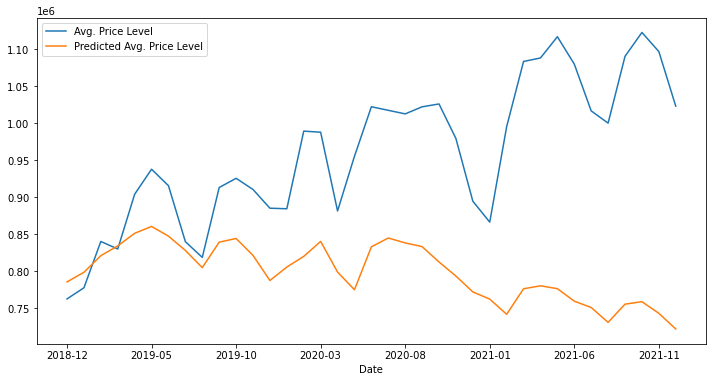

In [49]:
compare.reset_index().plot(x='Date', y=['Avg. Price Level', 'Predicted Avg. Price Level'],figsize=(12,6))

### Feature importance

OK, it's time to see which features affect housing prices in Toronto the most:

<AxesSubplot:title={'center':'Random Forest Regressor Feature Importance'}, xlabel='Normalized Feature Importance', ylabel='Features'>

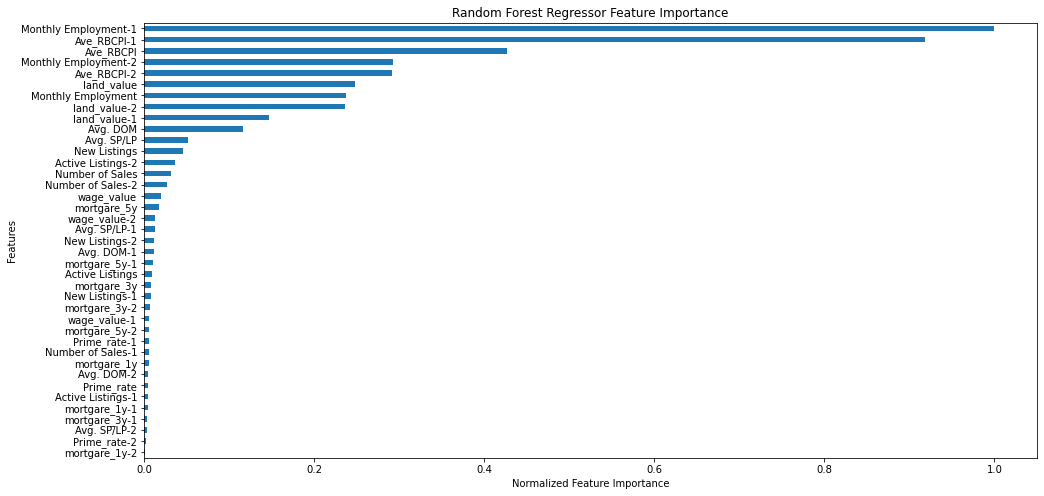

In [53]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Random Forest Regressor Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')

Very interesting observations:

* Three 'Monthly employment', 'Average residential building construction cost' and 'land value' along with their first and second lags are the most important features.<br>
<br>
* 'Average residential building construction cost' and 'land value' were also the top two parameters in correlation analysis. However, performing Granger causality test showed the 'Monthly Employment' is not an influencing factor in first three lags.<br>
<br>
* **Based on these results, the most important parameters affecting housing prices in Toronto are 'Average residential building construction cost' and 'land value'.**

# 4 - Summary, recommendations and future work

## Summary:

An analysis is conducted to find the two most important parameters that affect housing prices in city Toronto. To this end, datasets from six different public sources were gathered and compiled to analyze the influence of following parametrs on housing prices:<br>
<br>
* Real income<br>
* The cost of mortgages<br>
* Construction and development costs<br>
* Land availability<br> 
* Location and housing stock supply and demand<br>
* Job market prosperity

Three types of analysis is performed:<br>
<br>
1- Correlation analysis<br>
2- Granger causality test<br>
3- Random forest feature importance<br>

Results of this analysis suggest that 'Average residential building construction cost' and 'land value' are the most important parameters affecting housing prices in Toronto.<br>

## Recommendation:

Based on the results of this analysis and recommendations from Ontario Housing Affordability Task Force report in 2020 (https://www.ontario.ca/page/housing-affordability-task-force-report) one policy change is suggested that influences both identified parameters in order to reduce housing prices in Toronto:<br>

**Give the province the authority to impose standards related to zoning, density and urban design and lessen the power that cities have over housing developments.** <br>
This way, province can repeal municipal policies that focus on preserving a neighbourhood's character and reduce land prices especially for expensive neighbourhoods.<br> 
In addition, one of the factors that influence construction costs is very long project approval times; province can legislate timelines for development approvals, and if the municipality misses the deadline, the project gets an automatic green light.<br>

## Future work:
- I would meet with subject matter experts to understand the problem/data better, and find other useful data categories.
- This is a simplified model, more detailed parameters such as type of buillding (house, condo, etc.), demographic information on wges (age, sex, ype of employment, etc.), breakdown of employements to NAICS Sector (finance, mining, health care and social assistance, etc.), etc. can be added.
- Search for additional parameters that might affect housing prices in Toronto.
- Hyperparameter tune the random forest model.
- Try other algorithms for forecasting housing prices such as RNNs and LSTMs.





## Data sources:<br>

Number of Sales, Avg. Price Level, Median Price, New Listings, Active Listings, Avg. SP/LP, Avg. DOM:<br> from Toronto Regional Real Estate Board (TRREB):<br>
* Monthly home (all types) transactions: Market Watch Archive (Monthly): https://trreb.ca/index.php/market-news/market-watch/market-watch-archive

Residential building construction price index, new land price index and employee wages from Statistics Canada:
* Building construction price indexes, by type of building (quarterly): https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810013501

* New housing price index, monthly (Land only): https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810020501

* Employee wages by occupation, monthly: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410030601

Toronto Employment Survey from City of Toronto open data portal:
* Toronto Employment Survey (yearly): 
https://www.open.toronto.ca/dataset/toronto-employment-survey-summary-tables/


Mortgage rates: 
* bank of Canada: https://www.bankofcanada.ca/rates/banking-and-financial-statistics/posted-interest-rates-offered-by-chartered-banks/
